In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scipy
import tqdm
warnings.filterwarnings('ignore')

import sklearn.linear_model as lm
import sklearn.ensemble as en

import torch
import os
import sys
sys.path.append(os.path.abspath('../python'))

import train_arvae
import verify_causal_model

# DGP + Synthetic Control

$y_i(0) = \mu_i \lambda_t + \delta_t + \epsilon_{i,t}$ \
$y_i(1) = \alpha_{i,t} + y_i(0)$

In [2]:
def gen_data( n_donor=10, T=20, T0=12, noise=1 ):
    lmbda = np.random.normal(0,1,size=(T,1))
    delta = np.random.normal(0,1,size=(T,1))
    mu = np.random.normal(0,1,size=(1+n_donor,1))
    epsilon = noise*np.random.normal(0,1,size=(T,1+n_donor))
    y0 = np.matmul(lmbda,mu.T) + np.matmul(delta,np.ones((1,1+n_donor))) + epsilon
    y1 = y0
    intervention = np.zeros((T,1+n_donor))
    intervention[T0:T,0] = 1
    y = intervention*y1 + (1-intervention)*y0
    return y,intervention,y1,y0

def synthetic_control( y, T0 ):
    y_target = y[:,0]
    y_donors = y[:,1:]
    ypre_target = y[:T0,0]
    ypre_donors = y[:T0,1:]
    m_lasso = lm.LassoCV().fit(ypre_donors,ypre_target)
    y_target_lasso = m_lasso.predict(y_donors)
    effect = y_target - y_target_lasso
    return effect, y_target, y_target_lasso

In [62]:
n_donor=10 
T=30
T0=15
noise=1 
y,intervention,y1,y0 = gen_data( n_donor=n_donor, T=T, T0=T0, noise=noise )

In [63]:
y_target = y[:,0]
y_donors = y[:,1:]
ypre_target = y[:T0,0]
ypre_donors = y[:T0,1:]

In [64]:
effect, y_target, y_target_lasso = synthetic_control( y, T0 )

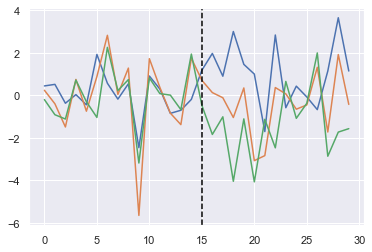

In [65]:
plt.plot(effect)
plt.plot(y_target)
plt.plot(y_target_lasso)
plt.axvline(T0,c='black',ls='--')

In [66]:
print(((np.mean(effect[:T0]),np.mean(effect[T0:]))))

(-2.2204460492503132e-17, 1.0422933175860036)


# Credence

## Training CREDENCE model

In [67]:
B = 1000
for i in range(B):
    y_,intervention_,y1_,y0_ = gen_data( n_donor=n_donor, T=T, T0=T0, noise=noise )
    y_donors_ = ( y_[:,1:] - np.mean(y_[:,1:]) ) / np.std(y_[:,1:])
    if i==0:
        data_ = y_donors_.reshape(T,1,n_donor)
    else:
        data_ = np.concatenate((data_,y_donors_.reshape(T,1,n_donor)),axis=1)

data_2d = train_arvae.convert_to_2d(data_)

In [68]:
print(f"Shape: {data_2d.shape}")
print(f"\nMean of raw data: {np.mean(data_2d):.3f}")
print(f"Std. dev of raw data: {np.std(data_2d):.3f}")

Shape: (1000, 300)

Mean of raw data: 0.000
Std. dev of raw data: 1.000


In [108]:
hyper_params = {}
hyper_params['epochs'] = 1000
hyper_params['latent_dim'] = 2 #Z
hyper_params['hidden_dims'] = [8,4]
hyper_params['kld_weight'] = 1
vae_model, runner = train_arvae.train(data_2d, hyper_params, output_checkpoint_path='ar_vae_coverage_2d.ckpt')

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name          | Type       | Params
---------------------------------------------
0 | encoder       | Sequential | 2.4 K 
1 | fc_mu         | Linear     | 10    
2 | fc_var        | Linear     | 10    
3 | decoder_input | Linear     | 12    
4 | decoder       | Sequential | 40    
5 | final_layer   | Sequential | 2.7 K 
---------------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


Loss Before Training
{'loss': tensor(1.1017, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(1.0667, grad_fn=<MseLossBackward>), 'KLD_Loss': tensor(0.0350, grad_fn=<MeanBackward0>), 'KLD_weight': 1}


Validation sanity check: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0984), 'kld_loss': tensor(0.0350), 'reconstruction_loss': tensor(1.0634)}


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0930), 'kld_loss': tensor(0.0323), 'reconstruction_loss': tensor(1.0607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0858), 'kld_loss': tensor(0.0294), 'reconstruction_loss': tensor(1.0564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0777), 'kld_loss': tensor(0.0263), 'reconstruction_loss': tensor(1.0514)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0703), 'kld_loss': tensor(0.0229), 'reconstruction_loss': tensor(1.0474)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0626), 'kld_loss': tensor(0.0194), 'reconstruction_loss': tensor(1.0432)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0561), 'kld_loss': tensor(0.0159), 'reconstruction_loss': tensor(1.0401)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0503), 'kld_loss': tensor(0.0129), 'reconstruction_loss': tensor(1.0374)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0461), 'kld_loss': tensor(0.0105), 'reconstruction_loss': tensor(1.0356)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0413), 'kld_loss': tensor(0.0087), 'reconstruction_loss': tensor(1.0326)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0371), 'kld_loss': tensor(0.0069), 'reconstruction_loss': tensor(1.0303)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0336), 'kld_loss': tensor(0.0052), 'reconstruction_loss': tensor(1.0285)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0304), 'kld_loss': tensor(0.0036), 'reconstruction_loss': tensor(1.0268)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0272), 'kld_loss': tensor(0.0023), 'reconstruction_loss': tensor(1.0249)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0246), 'kld_loss': tensor(0.0014), 'reconstruction_loss': tensor(1.0232)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0225), 'kld_loss': tensor(0.0009), 'reconstruction_loss': tensor(1.0216)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0213), 'kld_loss': tensor(0.0009), 'reconstruction_loss': tensor(1.0205)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0197), 'kld_loss': tensor(0.0011), 'reconstruction_loss': tensor(1.0187)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0191), 'kld_loss': tensor(0.0014), 'reconstruction_loss': tensor(1.0177)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0184), 'kld_loss': tensor(0.0017), 'reconstruction_loss': tensor(1.0167)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0175), 'kld_loss': tensor(0.0017), 'reconstruction_loss': tensor(1.0158)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0162), 'kld_loss': tensor(0.0017), 'reconstruction_loss': tensor(1.0145)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0154), 'kld_loss': tensor(0.0014), 'reconstruction_loss': tensor(1.0140)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0139), 'kld_loss': tensor(0.0012), 'reconstruction_loss': tensor(1.0127)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0132), 'kld_loss': tensor(0.0009), 'reconstruction_loss': tensor(1.0122)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0119), 'kld_loss': tensor(0.0007), 'reconstruction_loss': tensor(1.0112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0112), 'kld_loss': tensor(0.0006), 'reconstruction_loss': tensor(1.0106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0105), 'kld_loss': tensor(0.0005), 'reconstruction_loss': tensor(1.0101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0095), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(1.0091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0088), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(1.0084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0082), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(1.0078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0078), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(1.0074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0074), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(1.0070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0068), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(1.0064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0061), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(1.0058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0058), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(1.0055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0058), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(1.0055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0052), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(1.0050)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0047), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(1.0045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0043), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(1.0041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0040), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(1.0038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0035), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(1.0034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0031), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(1.0030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0032), 'kld_loss': tensor(8.9455e-05), 'reconstruction_loss': tensor(1.0031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0024), 'kld_loss': tensor(8.0577e-05), 'reconstruction_loss': tensor(1.0023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0024), 'kld_loss': tensor(7.6664e-05), 'reconstruction_loss': tensor(1.0023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0022), 'kld_loss': tensor(7.6593e-05), 'reconstruction_loss': tensor(1.0021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0022), 'kld_loss': tensor(7.8800e-05), 'reconstruction_loss': tensor(1.0021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0018), 'kld_loss': tensor(8.1686e-05), 'reconstruction_loss': tensor(1.0017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0015), 'kld_loss': tensor(8.3741e-05), 'reconstruction_loss': tensor(1.0014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0015), 'kld_loss': tensor(8.3573e-05), 'reconstruction_loss': tensor(1.0014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0011), 'kld_loss': tensor(8.0482e-05), 'reconstruction_loss': tensor(1.0010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0009), 'kld_loss': tensor(7.4283e-05), 'reconstruction_loss': tensor(1.0008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0010), 'kld_loss': tensor(6.5759e-05), 'reconstruction_loss': tensor(1.0009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0010), 'kld_loss': tensor(5.6047e-05), 'reconstruction_loss': tensor(1.0010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0005), 'kld_loss': tensor(4.6281e-05), 'reconstruction_loss': tensor(1.0004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0005), 'kld_loss': tensor(3.7566e-05), 'reconstruction_loss': tensor(1.0005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0006), 'kld_loss': tensor(3.0504e-05), 'reconstruction_loss': tensor(1.0006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0005), 'kld_loss': tensor(2.5360e-05), 'reconstruction_loss': tensor(1.0004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0002), 'kld_loss': tensor(2.2002e-05), 'reconstruction_loss': tensor(1.0002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0003), 'kld_loss': tensor(2.0063e-05), 'reconstruction_loss': tensor(1.0003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0003), 'kld_loss': tensor(1.9150e-05), 'reconstruction_loss': tensor(1.0003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0002), 'kld_loss': tensor(1.8791e-05), 'reconstruction_loss': tensor(1.0002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0002), 'kld_loss': tensor(1.8622e-05), 'reconstruction_loss': tensor(1.0002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0000), 'kld_loss': tensor(1.8302e-05), 'reconstruction_loss': tensor(0.9999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9999), 'kld_loss': tensor(1.7633e-05), 'reconstruction_loss': tensor(0.9999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9999), 'kld_loss': tensor(1.6469e-05), 'reconstruction_loss': tensor(0.9999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9999), 'kld_loss': tensor(1.4871e-05), 'reconstruction_loss': tensor(0.9999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9997), 'kld_loss': tensor(1.2960e-05), 'reconstruction_loss': tensor(0.9997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9998), 'kld_loss': tensor(1.0969e-05), 'reconstruction_loss': tensor(0.9998)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9997), 'kld_loss': tensor(9.0840e-06), 'reconstruction_loss': tensor(0.9997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9996), 'kld_loss': tensor(7.5169e-06), 'reconstruction_loss': tensor(0.9996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9997), 'kld_loss': tensor(6.3849e-06), 'reconstruction_loss': tensor(0.9997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9998), 'kld_loss': tensor(5.7254e-06), 'reconstruction_loss': tensor(0.9998)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9996), 'kld_loss': tensor(5.4992e-06), 'reconstruction_loss': tensor(0.9996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9997), 'kld_loss': tensor(5.6101e-06), 'reconstruction_loss': tensor(0.9997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9995), 'kld_loss': tensor(5.9172e-06), 'reconstruction_loss': tensor(0.9995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9996), 'kld_loss': tensor(6.2483e-06), 'reconstruction_loss': tensor(0.9996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9996), 'kld_loss': tensor(6.4721e-06), 'reconstruction_loss': tensor(0.9996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9995), 'kld_loss': tensor(6.4945e-06), 'reconstruction_loss': tensor(0.9995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9996), 'kld_loss': tensor(6.2878e-06), 'reconstruction_loss': tensor(0.9996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9995), 'kld_loss': tensor(5.8679e-06), 'reconstruction_loss': tensor(0.9995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9995), 'kld_loss': tensor(5.2815e-06), 'reconstruction_loss': tensor(0.9995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9996), 'kld_loss': tensor(4.6239e-06), 'reconstruction_loss': tensor(0.9996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9995), 'kld_loss': tensor(3.9534e-06), 'reconstruction_loss': tensor(0.9995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9994), 'kld_loss': tensor(3.3553e-06), 'reconstruction_loss': tensor(0.9994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9995), 'kld_loss': tensor(2.8708e-06), 'reconstruction_loss': tensor(0.9995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9995), 'kld_loss': tensor(2.5288e-06), 'reconstruction_loss': tensor(0.9995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9996), 'kld_loss': tensor(2.3261e-06), 'reconstruction_loss': tensor(0.9996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9995), 'kld_loss': tensor(2.2394e-06), 'reconstruction_loss': tensor(0.9995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9994), 'kld_loss': tensor(2.2258e-06), 'reconstruction_loss': tensor(0.9994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9994), 'kld_loss': tensor(2.2405e-06), 'reconstruction_loss': tensor(0.9994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(2.2306e-06), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9994), 'kld_loss': tensor(2.1747e-06), 'reconstruction_loss': tensor(0.9994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9994), 'kld_loss': tensor(2.0626e-06), 'reconstruction_loss': tensor(0.9994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9994), 'kld_loss': tensor(1.8964e-06), 'reconstruction_loss': tensor(0.9994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(1.7028e-06), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9994), 'kld_loss': tensor(1.4944e-06), 'reconstruction_loss': tensor(0.9994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9994), 'kld_loss': tensor(1.2966e-06), 'reconstruction_loss': tensor(0.9994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(1.1313e-06), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9994), 'kld_loss': tensor(1.0144e-06), 'reconstruction_loss': tensor(0.9994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(9.5091e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.2310e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(9.2081e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(9.2754e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(9.3761e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(9.3415e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.2062e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(8.8819e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(8.3744e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(7.7412e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9994), 'kld_loss': tensor(7.0863e-07), 'reconstruction_loss': tensor(0.9994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(6.3889e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(5.7764e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(5.2690e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(4.8869e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(4.6526e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.5484e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(4.5777e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.5552e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(4.4297e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(4.2722e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(4.0681e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(3.8157e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(3.5869e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.4505e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(3.3147e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(3.2120e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.1104e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(3.0423e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.9838e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.9069e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(2.8285e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7044e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5569e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.3791e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2164e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.0877e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9607e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8524e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7708e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7312e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(1.7273e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7356e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7266e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9993), 'kld_loss': tensor(1.6671e-07), 'reconstruction_loss': tensor(0.9993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5761e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5199e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4670e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3985e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3183e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2426e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1792e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1541e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0996e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0345e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0002e-07), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.9638e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.5185e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.1540e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.6499e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.0679e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.6447e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.3887e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.2801e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.2815e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.0045e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.7646e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.7160e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.5796e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.5798e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.2691e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.7176e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.2940e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.0627e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.9407e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.9379e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.6603e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.4934e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.1239e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.6640e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.8087e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.8426e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.7571e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.7212e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.3490e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.0771e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.8193e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.6258e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.6714e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7461e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7863e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7424e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.8344e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5168e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5334e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.3950e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5934e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5610e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.6213e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5332e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.9158e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.0776e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.9445e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.0043e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.9979e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7552e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.1019e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.3097e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.4373e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.2555e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.4252e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.0456e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.4237e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1121e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7529e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9366e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1234e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2018e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2987e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.4999e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7981e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.8130e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5894e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.0754e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8166e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2798e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4395e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0373e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1018e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.1307e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.0892e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.3651e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.6783e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0841e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3249e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5823e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4249e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3705e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2444e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3040e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2651e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0913e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1049e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.7786e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.9649e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.7209e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.8638e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.1339e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.2944e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.9540e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.8287e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.2590e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.5060e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.7814e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.4138e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.2566e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.6175e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.8243e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.3593e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.2406e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0174e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0954e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5117e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5449e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7408e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4056e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3201e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1554e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3240e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1440e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2919e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0274e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1509e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1444e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3454e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3042e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4305e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4491e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6388e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5629e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4322e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2975e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.9519e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.3260e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0964e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.6222e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0010e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.9665e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0367e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0179e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.3242e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.4918e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.7062e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.0841e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.8273e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0749e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.6147e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.4301e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.5623e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.8990e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.6613e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.7556e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.3276e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0382e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0060e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1081e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0990e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.4857e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.5549e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.3735e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.4639e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.0333e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.8431e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.6294e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.4694e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.5882e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.7013e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7362e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.5493e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0207e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.1155e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.3819e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.5251e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.4825e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.1381e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.7225e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.2338e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.4245e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.6108e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.1009e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.9716e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.3442e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.3572e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.1228e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.1614e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.7388e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.1167e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.1395e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.1109e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.0715e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.1593e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.2625e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.4913e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.5095e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.1451e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.4217e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.2298e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.6974e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.3376e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.1893e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.0680e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5330e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.0238e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.8638e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0025e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1625e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3059e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.5349e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.1009e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.6946e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.3740e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.6347e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.3325e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.5465e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.6848e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.3514e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.6299e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.8306e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.3684e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.9998e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.6590e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.6771e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.4382e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.8208e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.2934e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.0664e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.5381e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.8920e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.7300e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.7616e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.4059e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.1092e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.0946e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.5875e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.9938e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.3996e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.4687e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.7013e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.0217e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.8000e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.9251e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.7383e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.8967e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.9770e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.7106e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.6941e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.5169e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.2934e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.0701e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.1795e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.6038e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7844e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.0269e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2190e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9396e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9990e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8919e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7706e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3588e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0850e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.2196e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.7577e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0548e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2118e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5277e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6017e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3826e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3389e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.9128e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.8997e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.6632e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0861e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3325e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7341e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2354e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.6498e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7549e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7467e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5185e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1253e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6671e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3137e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2590e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4523e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3733e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1833e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1524e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.5067e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.3838e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.9442e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.5887e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.5889e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.5251e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.7190e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5290e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8949e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.3069e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.4186e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1899e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9930e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9725e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6216e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2634e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.6727e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.6706e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.9749e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.8944e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2789e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5760e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.0808e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.3175e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2858e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9465e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6944e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3217e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0774e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.6180e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.4729e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.2156e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.4843e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0129e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0459e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.0746e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.8303e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.8527e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.0655e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.5030e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2454e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0595e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0591e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0177e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.0522e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.7467e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.8732e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.0895e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.4524e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1176e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5356e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2421e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.3847e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5906e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5427e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2683e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8690e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4804e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0593e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.5621e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0902e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8938e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.0426e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.9106e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.5514e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.4372e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.9348e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.1160e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.3773e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7231e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7488e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1352e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.3665e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.3549e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.9197e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.8265e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.7300e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.6442e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.9952e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.6631e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7213e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.6746e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.2403e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.6112e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.9102e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.4089e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.9526e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.8192e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.5342e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.9084e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.5806e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7439e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.3274e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5621e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.5670e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.2440e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.8282e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.2638e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.7870e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.8953e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.0888e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2100e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9819e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6771e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7881e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2223e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7791e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.8949e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.9383e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.8815e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7960e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7139e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.3130e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.0403e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4152e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3568e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.7957e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.5237e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0425e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.0785e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.3707e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.9307e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.6028e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.4550e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.5244e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.2540e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.0773e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.3118e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1253e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8310e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.5409e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.2559e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.3828e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.2205e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.6678e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.8080e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.1509e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1401e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0082e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2670e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1548e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5385e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5553e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1662e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1181e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2971e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7470e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.4419e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5785e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1638e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.0470e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6462e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4184e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2167e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0237e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.7505e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.0368e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.5800e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.8778e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9092e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.4866e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.4273e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5723e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7325e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.7237e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.5539e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.1888e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.6822e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5388e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.9209e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.6580e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.5581e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.9751e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.8948e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.8466e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0332e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3746e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4400e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5324e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1206e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.3188e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.6743e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.5714e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.5486e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.9504e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.7598e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.6909e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.7901e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0511e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3832e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3143e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8252e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9385e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9146e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5648e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1986e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.3617e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.0487e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.6219e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.1020e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.8152e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.6347e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0069e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6658e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.4717e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.8411e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7297e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8742e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6131e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1055e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0980e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1889e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1437e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.3356e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.6002e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.4233e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.6382e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.4201e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.5758e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.4202e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.4904e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1691e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2911e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.9854e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.1454e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.3677e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.1522e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.8044e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.3462e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7809e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2890e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0593e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3227e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5328e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1260e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.3510e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.3527e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2177e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9081e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9366e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5093e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4186e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1958e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.5572e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.8042e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.7239e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.4576e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.5868e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.5549e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.5477e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.8958e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.4261e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.4634e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.7553e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.8133e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.3558e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.7435e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0140e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0626e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2234e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3547e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4059e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0286e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.9104e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.2992e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.9512e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.5453e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.6855e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.6411e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1349e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0554e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.9947e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.2161e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0338e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4709e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3718e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1694e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.5120e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.6015e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.1393e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.9418e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.8075e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.9304e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.9884e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2157e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2346e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.2578e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.5124e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.1085e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.1143e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.1559e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.9331e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.3192e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3957e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1547e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2333e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.5067e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.9856e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2545e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9932e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7033e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.5644e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.9812e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.4104e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.6203e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.9230e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.6238e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.9404e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.8929e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1158e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.4468e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.2019e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.9807e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.6734e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.1996e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.5669e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.3173e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.7810e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.4649e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.6895e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1398e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5918e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3834e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.6501e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.8343e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0740e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4484e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2754e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7359e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.8701e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.2462e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.2594e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.8981e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2244e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3269e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.5586e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0571e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5838e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1691e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.8582e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.1434e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.7538e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.0218e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.7987e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.1836e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2504e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8107e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4257e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2180e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0377e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.2604e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.6997e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.1870e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.3011e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.2902e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.2899e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.1223e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.4219e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.4107e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.0345e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8477e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.5768e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.3183e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2338e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4402e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6451e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6022e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7740e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5581e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5400e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3793e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.6392e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.4843e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.6664e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.7048e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.9523e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.2524e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.6364e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0269e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.2753e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.9314e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.3344e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.9174e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.7833e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.4038e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.3889e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.0257e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.2454e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.5672e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.0084e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.3248e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.1316e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.7281e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2575e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5047e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.4525e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.5980e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.6853e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.8950e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.1479e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.7055e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.4059e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7584e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8716e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6360e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1387e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.4092e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.2325e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.1552e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.7877e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.5619e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.0844e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.8770e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5582e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1473e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9068e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8295e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6227e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5380e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6280e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4523e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8187e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.6040e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7671e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.6135e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1920e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8489e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5017e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4044e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2083e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.3970e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2200e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.0448e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.4389e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.4394e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.6079e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.0443e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.2745e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.5504e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1458e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.9823e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.8967e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.8298e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.7907e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.4639e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2826e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4376e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7503e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.0124e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9019e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8733e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9737e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6818e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7310e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6529e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7351e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5145e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2139e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.7649e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7623e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8906e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.7088e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.5972e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1228e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2716e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3329e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(9.1288e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.3367e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.0792e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.7255e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.3716e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.6781e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3327e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9902e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.4972e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5723e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5168e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2082e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6140e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.2988e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3590e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4909e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.0854e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7571e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.3580e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.1088e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.2267e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.2209e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.5830e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.6433e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.9031e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1165e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0431e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.0813e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3290e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7339e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.0875e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2138e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.0726e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2482e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1810e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.4015e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1338e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.0502e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7982e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6363e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6700e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3515e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.1206e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.5011e-09), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3154e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5995e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.4183e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.6502e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.5160e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.0600e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.4033e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.0507e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(6.0463e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.5156e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7671e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8876e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.0808e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.5873e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.0560e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.0740e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.2679e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(8.3951e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(7.3493e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(5.6976e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.1163e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7867e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2251e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.0770e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5189e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.1423e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.5642e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.0229e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.6154e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.1896e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.6198e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.1562e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6846e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.4300e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.3720e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8453e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.2719e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.9091e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.3021e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.4843e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.0059e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.7094e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.0960e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.7360e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.5544e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.6280e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(1.8040e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(2.5120e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(3.4308e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.2943e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.3722e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.3366e-08), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(4.1412e-08), 'reconstruction_loss': tensor(0.9992)}
Loss After Training
{'loss': tensor(0.9992, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.9992, grad_fn=<MseLossBackward>), 'KLD_Loss': tensor(4.1412e-08, grad_fn=<MeanBackward0>), 'KLD_weight': 1}


## Visualizing Latent space

In [109]:
pi_tr = vae_model.encode(torch.tensor(data_2d).float())
mu_tr, logvar_tr = pi_tr
mu_tr_df = pd.DataFrame(mu_tr.detach().numpy()[0,:,:],columns=['Z%d'%(i) for i in range(vae_model.latent_dim)])
# mu_tr_df['series'] = series_names

In [132]:
torch.exp(0.5 * logvar_tr)

tensor([[[0.9999, 1.0001],
         [0.9999, 1.0001],
         [1.0000, 1.0000],
         ...,
         [0.9999, 1.0000],
         [0.9999, 1.0001],
         [1.0000, 1.0000]]], grad_fn=<ExpBackward>)

No handles with labels found to put in legend.


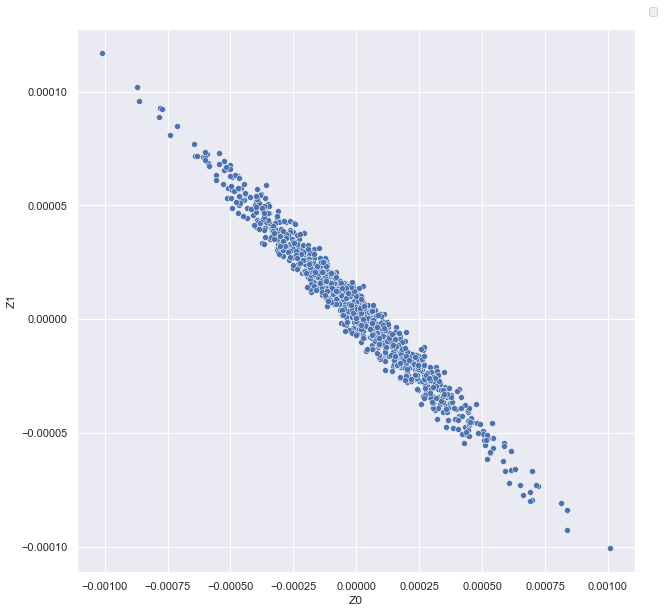

In [110]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='Z0',y='Z1',data=mu_tr_df)
plt.legend(bbox_to_anchor=(1.05, 1.05))

## Functions for Confidence Interval Estimation using CREDENCE

In [111]:
def gen_donor_samples(donor_normalized,vae_model,N,T,num_samples = 50):
    pi = vae_model.encode(donor_normalized)
    mu, logvar = pi
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    Z = vae_model.reparameterize(pi, eps) 
    S = train_arvae.generate_example_sample(vae_model, 0, 1, T, num_samples, N, latent_values=Z)
    return S

In [122]:
def credence_ci(y, vae_model, N, T0, num_samples = 50,noise=1,y_clean=[]):
    samples = []
    
    y_target = y[:,0]
    y_donors = y[:,1:]
    ypre_target = y[:T0,0]
    ypre_donors = y[:T0,1:]
    
    donor_mean = np.mean(y_donors)
    donor_std = np.std(y_donors)
    
    ypre_target_ = (ypre_target-donor_mean)/donor_std
    ypre_donor_ = (ypre_donors-donor_mean)/donor_std
    y_target_ = (y_target-donor_mean)/donor_std
    y_donor_ = (y_donors-donor_mean)/donor_std
    y_ = (y-donor_mean)/donor_std
    
#     print(f"\nMean of raw data: {np.mean(y_target_):.3f}")
#     print(f"Std. dev of raw data: {np.std(y_target_):.3f}")
    
    effect0, y_target_, y_target_lasso_ = synthetic_control( y_, T0 )
    
    effect = []
    
    T = y.shape[0]

    obs_data_norm = torch.tensor(y_donor_.reshape(1,-1)).float()*torch.ones(num_samples,N*T)
    S = gen_donor_samples(obs_data_norm,vae_model,N,T,num_samples = num_samples)
    for i in range(num_samples):
        Si = (S[:,i,:] - np.mean(S[:,i,:]))/np.std(S[:,i,:]) #gen_data(n_donor=N, T=T, T0=T0, noise=noise)[0][:,1:] #S[:T,i,:N]
#         if len(y_clean)!=0:
#             Si = y_clean[:,1:] + noise*np.random.normal(0,1,size=y_clean[:,1:].shape) #S[:T,i,:N]
        y_sample_ = np.hstack((y_target_.reshape(-1,1),Si))
        effect_i, y_target_sample, y_target_sample_lasso = synthetic_control( y_sample_, T0 )
        
        effect += [effect_i]
    
    effect = (np.array(effect).T) * donor_std
    return effect0*donor_std, effect

## Coverage Analysis

In [123]:
n_donor=10 
vae_model = vae_model
N = n_donor
T=30
T0=15
repeats = 100
num_samples = 50
np.random.seed(0)

y_clean,intervention,y1,y0 = gen_data( n_donor=n_donor, T=T, T0=T0, noise=0 )
coverage_dict = pd.DataFrame()
effect_df_pre = pd.DataFrame()
effect_df_post = pd.DataFrame()
for noise in tqdm.tqdm([1.0,2.0]):
    coverage = 0.0
    for repeat in (range(repeats)):
        y = y_clean + noise * np.random.normal(0,1,size=(y_clean.shape))
        y_target = y[:,0]
        y_donors = y[:,1:]
        ypre_target = y[:T0,0]
        ypre_donors = y[:T0,1:]
        effect0, effect = credence_ci(y, vae_model, N=N, T0=T0, num_samples=num_samples,noise=noise,y_clean=y_clean)
        effect_df_pre['%d_%.1f'%(repeat,noise)] = np.mean(effect[:T0,:],axis=0)
        effect_df_post['%d_%.1f'%(repeat,noise)] = np.mean(effect[T0:,:],axis=0)
        mean_effect = np.mean(effect_df_post['%d_%.1f'%(repeat,noise)])
        std_effect = np.sqrt(np.sum(np.cov(effect[T0:,:]))/(num_samples))
        if (0 <= mean_effect+2*std_effect) and (0 >= mean_effect-2*std_effect):
            coverage += 1
    coverage_dict[noise] = [coverage/repeats]

100%|██████████| 2/2 [08:28<00:00, 254.22s/it]


In [115]:
coverage_dict.to_csv('coverage_credence_resampling.csv')
effect_df_pre.to_csv('pre_intervention_effect_credence_resampling.csv')
effect_df_post.to_csv('post_intervention_effect_credence_resampling.csv')

In [124]:
coverage_dict

,1.0,2.0
0,0.01,0.09


In [125]:
donor_mean = np.mean(y_donors)
donor_std = np.std(y_donors)

ypre_target_ = (ypre_target-donor_mean)/donor_std
ypre_donor_ = (ypre_donors-donor_mean)/donor_std
y_target_ = (y_target-donor_mean)/donor_std
y_donor_ = (y_donors-donor_mean)/donor_std
y_ = (y-donor_mean)/donor_std

obs_data_norm = torch.tensor(y_donor_.reshape(1,-1)).float()*torch.ones(num_samples,N*T)
S = gen_donor_samples(obs_data_norm,vae_model,N,T,num_samples = num_samples)


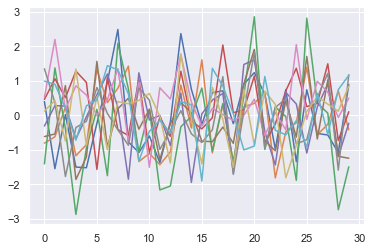

In [126]:
plt.plot(y_donor_)

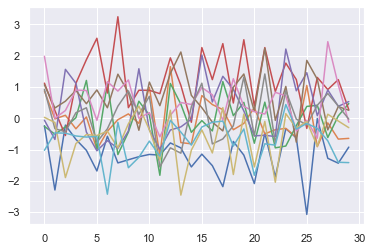

In [131]:
i = 0
plt.plot((S[:,i,:]-np.mean(S[:,i,:]))/np.std(S[:,i,:]))

In [129]:
effect_df_post

,0_1.0,1_1.0,2_1.0,3_1.0,4_1.0,5_1.0,6_1.0,7_1.0,8_1.0,9_1.0,...,90_2.0,91_2.0,92_2.0,93_2.0,94_2.0,95_2.0,96_2.0,97_2.0,98_2.0,99_2.0
0,-0.071254,0.917437,0.22969,0.142749,0.654296,0.419185,0.142251,-0.11241,0.30404,0.53882,...,-0.296696,0.604707,0.454184,-1.010125,0.371665,-0.551551,0.295578,0.895353,0.375809,0.191317
1,-0.071254,0.917437,0.22969,0.142749,0.654296,0.419185,0.142251,-0.11241,0.30404,0.53882,...,-0.296696,0.606142,0.454184,-1.010125,0.332962,-0.551551,0.287757,0.892428,0.327921,0.191317
2,-0.071254,0.917437,0.22969,0.142749,0.654296,0.419185,0.142251,-0.11241,0.30404,0.53882,...,-0.296696,0.605600,0.454184,-1.010125,0.480715,-0.551551,0.308994,0.827628,0.308983,0.191317
3,-0.071254,0.917437,0.22969,0.142749,0.654296,0.419185,0.142251,-0.11241,0.30404,0.53882,...,-0.296696,0.569753,0.454184,-1.010125,0.502398,-0.551551,0.298766,0.938240,0.321681,0.191317
4,-0.071254,0.917437,0.22969,0.142749,0.654296,0.419185,0.142251,-0.11241,0.30404,0.53882,...,-0.296696,0.672107,0.454184,-1.010125,0.430949,-0.551551,0.284116,0.827628,0.377716,0.191317
5,-0.071254,0.917437,0.22969,0.142749,0.654296,0.419185,0.142251,-0.11241,0.30404,0.53882,...,-0.296696,0.604948,0.454184,-1.010125,0.409251,-0.551551,0.286057,0.893532,0.325103,0.191317
6,-0.071254,0.917437,0.22969,0.142749,0.654296,0.419185,0.142251,-0.11241,0.30404,0.53882,...,-0.296696,0.616739,0.454184,-1.010125,0.512229,-0.551551,0.302610,1.033687,0.321349,0.191317
7,-0.071254,0.917437,0.22969,0.142749,0.654296,0.419185,0.142251,-0.11241,0.30404,0.53882,...,-0.296696,0.605657,0.454184,-1.010125,0.448186,-0.551551,0.293590,0.863778,0.321603,0.191317
8,-0.071254,0.917437,0.22969,0.142749,0.654296,0.419185,0.142251,-0.11241,0.30404,0.53882,...,-0.296696,0.605818,0.454184,-1.010125,0.449656,-0.551551,0.285778,0.880313,0.313683,0.191317
9,-0.071254,0.917437,0.22969,0.142749,0.654296,0.419185,0.142251,-0.11241,0.30404,0.53882,...,-0.296696,0.692772,0.454184,-1.010125,0.399566,-0.551551,0.294106,0.827628,0.363692,0.191317
